In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom package where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform

import Surrogates.PolynomialChaosExpansion as PCE

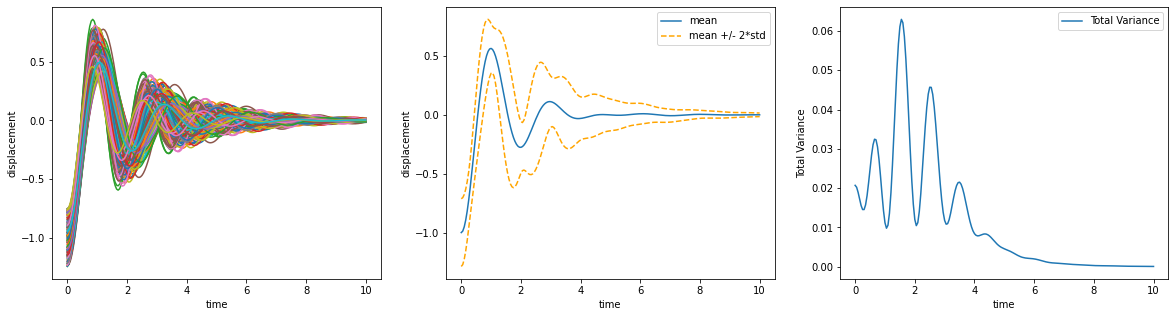

In [3]:
N = 20_000 # number of 'instances'/'realisations'
n = 200  # discretization in time

t = np.linspace(0, 10, n+1) # row vector
T = np.tile(t, (N, 1)) # repeat row 't' along axis 0

X = mech_oscillator_samples(N)
Y = mech_oscillator(X,T)

Y_mean = np.mean(Y,axis=0) # compute mean for each t_i
Y_var = np.var(Y,axis=0) # compute var for each t_i
Y_std = np.std(Y,axis=0) # compute std for each t_i

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')

'Plot the mean and 2 stds of random process'
ax[1].plot(t,Y_mean, '-', label = 'mean')
ax[1].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[1].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].legend()

'Plot the variance of random process'
ax[2].plot(t,Y_var, '-', label = 'Total Variance')
ax[2].set_ylabel('Total Variance')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

In [4]:
# PCE Surrogate
total_polynomial_degree = 7
number_of_random_variables = N_p = 3
polynomial_classes_of_random_variables = [PCE.Legendre]*number_of_random_variables

PCE_t_i = PCE.PCE_surrogate(total_polynomial_degree, polynomial_classes_of_random_variables, mech_oscillator_isoprob_transform)

# Points where Sobol indices must be computed
inspection_points = 100
I = np.linspace(0 , n, inspection_points, dtype=int)
T = np.linspace(0, 10, n+1) # row vector

# store indices
S = np.zeros((N_p, inspection_points))
S_T = np.zeros((N_p, inspection_points))

# store LOO error
LOO_error = np.zeros((inspection_points, 1))

for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

    X_hat = X
    Y_hat = Y.T[time_index, :]

    _ = PCE_t_i.find_coefficients(X_hat, Y_hat)

    # store error at each t_i
    LOO_error[j] = PCE_t_i.LeaveOneOut(X_hat, Y_hat)

    # Sobol Indices
    S_first, S_tot = PCE_t_i.Sobol_Indices()

    S[:, j] = S_first
    S_T[:, j] = S_tot

Computing Indices: 100%|██████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


# Plot

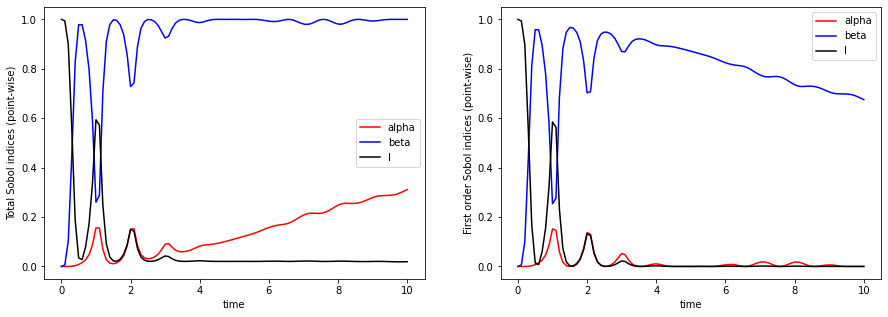

In [5]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T[I], S_T[0,:], '-', color = 'red', label = 'alpha')
ax[0].plot(T[I], S_T[1,:], '-', color = 'blue', label = 'beta')
ax[0].plot(T[I], S_T[2,:], '-', color = 'black', label = 'l')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T[I], S[0,:], '-', color = 'red', label = 'alpha')
ax[1].plot(T[I], S[1,:], '-', color = 'blue', label = 'beta')
ax[1].plot(T[I], S[2,:], '-', color = 'black', label = 'l')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()

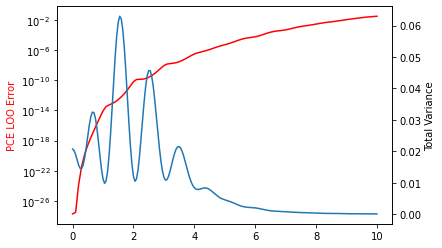

In [6]:
fig, ax = plt.subplots()

ax.semilogy(T[I], LOO_error, color = 'red', label = 'PCE LOO Error')
ax.set_ylabel("PCE LOO Error", color = 'red')

ax2 = ax.twinx()
ax2.plot(t,Y_var, '-', label = 'Total Variance')
ax2.set_ylabel("Total Variance")

plt.show()